# Assignment 1: Topic 1 and 2
**********

**Course**: Predictive modeling <br>

**Date**: December 19, 2025



## Introduction
Every year since 2011 Stack Overflow conducts a survey and publishes results with insights into the state of the Software Development and Information Technology industry. This year survey had participants from 177 countries. Since 2023 the survey includes questions about AI tools and this year was no exception. In fact, the section on AI and its use was expanded this year.

## Dataset
2025 Stack Overflow Developer Survey <br>
**Source**: https://survey.stackoverflow.co/2025

**Link to the dataset:** https://survey.stackoverflow.co/datasets/stack-overflow-developer-survey-2025.zip

Original dataset survey_results_public.csv contains 49,191 responses to 62 questions. It includes questions of several groups, such as Developers, Technology, AI, Work and Stack Overflow. 

### Developers
This section of questions is subdivided into three groups: Profile, Education & Experience and Developer roles. In the analysis this is one of the sections I will use.

#### Some questions
1. Are you someone who writes code?
2. What is your age?
3. Where do you live?
4. Which of the following best describes the highest level of formal education that you’ve completed? 
5. Including any education, how many years have you been coding in total? 
6. Did you spend time in the last year learning AI programming or AI-enabled tooling on your own or at work?
7. How did you learn to code for AI in the past year? 
8. How many years of professional work experience do you have?

#### Corresponding variables
Most of the answers are categorical variables, with the exception of questions where respondents typed the number of years (continuous variable).
- MainBranch
- Age
- Country
- EdLevel
- YearsCode
- LearnCodeAI
- AILearnHow
- WorkExp

### Technology
This section is subdivided into three groups: Most popular technologies, Admired and Desired, and Worked with vs. want to work with.

#### Some questions
1. Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?
2. Which database environments have you done extensive development work in over the past year, and which do you want to work in over the next year?
3. Which cloud platforms, containerization/orchestration tools, package managers, build tools, and infrastructure as code solutions have you done extensive development work in over the past year, and which do you want to work in over the next year?
4. Which development environments and AI-enabled code editing tools did you use regularly over the past year, and which do you want to work with over the next year?
5. Which LLM models for AI tools have you used for development work in the past year, and which would you like to use next year?

#### Corresponding variables
The raw answers are categorical (multi-select options). For the analysis, I transformed these into numerical variables representing the count of technologies known (e.g., LanguageHaveWorkedWith_Count) to measure the breadth of a developer's skill set.
- LanguageHaveWorkedWith
- DatabaseHaveWorkedWith
- PlatformHaveWorkedWith
- DevEnvsHaveWorkedWith
- AIModelsHaveWorkedWith

### AI
This section is subdivided into three groups: Sentiment and usage, Developer tools, and AI Agents.

#### Some questions
1. Do you currently use AI tools in your development process?
2. How favorable is your stance on using AI tools as part of your development workflow?
3. Are you using AI agents in your work (development or otherwise)?

#### Corresponding variables
All of the answers are categorical variables.
- AISelect
- AISent
- AIAgents

### Work
This section is subdivided into five groups: Employment, Company info, Salary, Technology purchases, and Job satisfaction. In the analysis I will be mostly using Employment and Salary subsections.

#### Some questions
1. Which of the following best describes your current employment status?
2. Which of the following additional activities are you currently engaged in?
3. What is your current total annual compensation (salary, bonuses, and perks, before taxes and deductions) in terms of your day-to-day currency?
4. Do you believe AI is a threat to your current job?

#### Corresponding variables
Most answers are categorical, with the exception of ConvertedCompYearly, which is a continuous numerical variable used as the target for the Linear Regression model.
- Employment
- EmploymentAddl
- ConvertedCompYearly
- AIThreat

## Goal
The primary objective of this case study is to develop two distinct predictive models to analyze the modern software developer landscape using the 2025 Stack Overflow Annual Survey.

### Linear regression
The goal of this study is to predict the total annual compensation for software developers globally. To do this prediction, the study aims to isolate and rank the most significant drivers of salary. 

### GLM
The goal of this study is to predict the likelihood of a given developer adopting AI tools. To get the most accurate model I rank the most relevant variables to the AI usage.

### The process
Data is uploaded and cleaned. In this section I also create variables that are used in the analysis. Then each section contains the following topics:
1. Exploratory data analysis / Visualizations
1. Correlation matrix
1. Model development
1. Model Evaluation
1. Prediction intervals


# Data preparation
In this section I import libraries, load the dataset, clean the variables, create new ones that are easier and more appropriate to work with, and split the data into training and testing set that will be used further for analysis.

In [276]:
# Importing necessary libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, accuracy_score, classification_report, roc_curve, auc, recall_score, precision_score
import warnings

In [277]:
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [278]:
# Loading data
df = pd.read_csv('survey_results_public.csv', low_memory=False)

# Pre-processing
cols_needed = [
    'MainBranch', 'Age', 'Country', 'EdLevel', 'YearsCode', 
    'LearnCodeAI', 'AILearnHow', 'WorkExp', 
    'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 
    'PlatformHaveWorkedWith', 'DevEnvsHaveWorkedWith', 'AIModelsHaveWorkedWith',
    'AISelect', 'AISent', 'AIAgents', 'Employment', 'EmploymentAddl', 
    'ConvertedCompYearly', 'AIThreat'
]
df = df[cols_needed].copy()

# Clean salary
df = df.dropna(subset=['ConvertedCompYearly', 'Country'])
valid_countries = df['Country'].value_counts()[lambda x: x > 50].index
df = df[df['Country'].isin(valid_countries)]

# Standardizing salary across countries based on Z-score
def standardize_salary(group):
    if group.std() == 0: return 0
    return (group - group.mean()) / group.std()

df['Log_Salary'] = np.log1p(df['ConvertedCompYearly'])
df['Salary_ZScore'] = df.groupby('Country')['Log_Salary'].transform(standardize_salary)
df = df[(df['Salary_ZScore'] >= -3) & (df['Salary_ZScore'] <= 3)]

# Cleaning AISelect and creating a binary variable UsesAI
df = df.dropna(subset=['AISelect'])

def get_ai_binary(response):
    if 'Yes' in str(response): return 1
    elif 'No' in str(response): return 0
    return np.nan

df['UsesAI'] = df['AISelect'].apply(get_ai_binary)

# Handling columns that list multiple tools and languages
tech_cols = [
    'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 
    'PlatformHaveWorkedWith', 'DevEnvsHaveWorkedWith', 'AIModelsHaveWorkedWith'
]

for col in tech_cols:
    df[col] = df[col].fillna('')
    df[f'{col}_Count'] = df[col].apply(lambda x: x.count(';') + 1 if x != '' else 0)

# Handling AILearnHow variable: creating four groups based on how responders learnt AI
df['AILearnHow'] = df['AILearnHow'].fillna('')

# Learning online:
online_keywords = [
    'AI CodeGen', 'Other online resources', 'Videos', 
    'Blogs', 'Games', 'Online Courses'
]
df['Learn_Online'] = df['AILearnHow'].apply(lambda x: 1 if any(k in x for k in online_keywords) else 0)

# Learning from documentation/text:
doc_keywords = ['Technical documentation', 'Books']
df['Learn_Docs'] = df['AILearnHow'].apply(lambda x: 1 if any(k in x for k in doc_keywords) else 0)

# Learning at work:
df['Learn_Work'] = df['AILearnHow'].apply(lambda x: 1 if 'Colleague' in x else 0)

# Learning through formal education:
formal_keywords = ['School', 'Coding Bootcamp']
df['Learn_Formal'] = df['AILearnHow'].apply(lambda x: 1 if any(k in x for k in formal_keywords) else 0)

# Cleaning Age and work experience columns (variables WorkExp and YearsCode)
df = df.dropna(subset=['Age'])
df = df[df['Age'] != 'Prefer not to say']

age_map_max = {
    '18-24 years old': 24,
    '25-34 years old': 34,
    '35-44 years old': 44,
    '45-54 years old': 54,
    '55-64 years old': 64,
    '65 years or older': 100
}
df['Max_Age_Proxy'] = df['Age'].map(age_map_max)

experience_cols = ['YearsCode', 'WorkExp']
for col in experience_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df[df[col] <= 50] 
    mask_impossible = df[col] > (df['Max_Age_Proxy'] - 5)
    df = df[~mask_impossible]

df = df[df['WorkExp'] <= df['YearsCode']]

# Cleaning Education
df = df.dropna(subset=['EdLevel'])

def clean_education(x):
    if pd.isna(x): return np.nan
    if 'Bachelor' in x: return 'Bachelor'
    if 'Master' in x: return 'Master'
    if 'Professional' in x or 'doctoral' in x.lower(): return 'Post Grad'
    if 'Associate' in x: return 'Associate'
    return 'No Degree'

df['EdLevel_Clean'] = df['EdLevel'].apply(clean_education)

# Cleaning AI sentiment
sentiment_map = {
    'Very unfavorable': 1,
    'Unfavorable': 2,
    'Indifferent': 3,
    'Unsure': 3,          
    'Favorable': 4,
    'Very favorable': 5
}
df['AISent_Score'] = df['AISent'].map(sentiment_map)

# Cleaning AIAgents and creating a binary variable Uses_AIAgents
df = df.dropna(subset=['AIAgents'])

df['Uses_AIAgents'] = df['AIAgents'].apply(get_ai_binary)

# Cleaning Employment
def clean_employment(x):
    val = str(x).lower()
    if 'independent' in val: return 'Freelance'
    elif 'student' in val: return 'Student'
    elif 'employed' in val and 'not' not in val: return 'Employed'
    else: return 'Not Employed'

df['Employment_Clean'] = df['Employment'].apply(clean_employment)
df['Is_Freelance'] = df['Employment_Clean'].apply(lambda x: 1 if x == 'Freelance' else 0)
df['Is_Student'] = df['Employment_Clean'].apply(lambda x: 1 if x == 'Student' else 0)
df['Is_NotEmployed'] = df['Employment_Clean'].apply(lambda x: 1 if x == 'Not Employed' else 0)

# Cleaning EmploymentAddl
df['EmploymentAddl'] = df['EmploymentAddl'].fillna('None')
df['Addl_SideHustle'] = df['EmploymentAddl'].apply(lambda x: 1 if 'paid work' in str(x) else 0)
df['Addl_Caregiving'] = df['EmploymentAddl'].apply(lambda x: 1 if 'dependents' in str(x) else 0)
df['Addl_Studying'] = df['EmploymentAddl'].apply(lambda x: 1 if 'school' in str(x) else 0)

# Final cleaned dataset
final_cols = [
    'Salary_ZScore',            
    'UsesAI',                   
    'Max_Age_Proxy', 
    'Age',
    'EdLevel_Clean', 
    'YearsCode', 
    'WorkExp', 
    'Country',
    'Is_Freelance', 
    'Is_Student',
    'Is_NotEmployed',
    'Addl_SideHustle', 
    'Addl_Caregiving', 
    'Addl_Studying',
    'Learn_Online', 
    'Learn_Docs', 
    'Learn_Work', 
    'Learn_Formal',
    'AISent_Score', 
    'Uses_AIAgents'
    
] + [c + '_Count' for c in tech_cols]

df_final = df.dropna(subset=final_cols)
df_final = df_final[final_cols]

print(f"Data Cleaned. Rows ready for modeling: {len(df_final)}")

Data Cleaned. Rows ready for modeling: 18974


Data has been successfully cleaned. 

In order to completely remove the influence of a country's economy on a given salary I decided to count the salaries relatively within each country by using Z score.

Splitting the data into training and testing sets, and then visualizing the result:

In [279]:
# Creating a training and testing dataset (80/20 split)
train_data, test_data = train_test_split(df_final, test_size=0.2, random_state=123)
print(f"Total Rows: {len(df_final)}")
print(f"Training Set: {len(train_data)} rows (80%)")
print(f"Test Set: {len(test_data)} rows (20%)")

# Visualizing dataset
print("\n--- Structure of Training Data ---")
train_data.info()

print("\n--- First 5 Rows ---")
display(train_data.head())

Total Rows: 18974
Training Set: 15179 rows (80%)
Test Set: 3795 rows (20%)

--- Structure of Training Data ---
<class 'pandas.core.frame.DataFrame'>
Index: 15179 entries, 8170 to 38367
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Salary_ZScore                 15179 non-null  float64
 1   UsesAI                        15179 non-null  int64  
 2   Max_Age_Proxy                 15179 non-null  int64  
 3   Age                           15179 non-null  object 
 4   EdLevel_Clean                 15179 non-null  object 
 5   YearsCode                     15179 non-null  float64
 6   WorkExp                       15179 non-null  float64
 7   Country                       15179 non-null  object 
 8   Is_Freelance                  15179 non-null  int64  
 9   Is_Student                    15179 non-null  int64  
 10  Is_NotEmployed                15179 non-null  int64  
 11  Addl_SideH

,Salary_ZScore,UsesAI,Max_Age_Proxy,Age,EdLevel_Clean,YearsCode,WorkExp,Country,Is_Freelance,Is_Student,...,Learn_Docs,Learn_Work,Learn_Formal,AISent_Score,Uses_AIAgents,LanguageHaveWorkedWith_Count,DatabaseHaveWorkedWith_Count,PlatformHaveWorkedWith_Count,DevEnvsHaveWorkedWith_Count,AIModelsHaveWorkedWith_Count
8170,0.573227,1,54,45-54 years old,Master,25.0,25.0,United Kingdom of Great Britain and Northern I...,0,0,...,1,0,0,5.0,1,7,3,5,7,0
23482,-0.220909,1,44,35-44 years old,Master,20.0,18.0,Portugal,1,0,...,0,0,0,5.0,1,0,0,0,0,0
39388,-0.924637,1,24,18-24 years old,Master,4.0,2.0,India,0,0,...,0,1,1,4.0,0,0,0,0,0,0
43332,-0.854517,0,24,18-24 years old,Bachelor,9.0,3.0,Canada,0,0,...,0,0,0,2.0,0,5,0,6,6,0
38639,-0.189327,1,34,25-34 years old,Master,8.0,3.0,Ireland,0,0,...,1,0,0,4.0,0,10,5,10,2,7


# Linear Regression

## Exploratory Data Analysis
Here I look at summary statistics for the dataset after the cleaning, to see the dataset that I'm left with.

In [280]:
# Summary statistics
print("\n--- Summary Statistics (Numerical) ---")
display(train_data.describe())

print("\n--- Summary Statistics (Categorical) ---")
display(train_data.describe(include=['object']))


--- Summary Statistics (Numerical) ---


,Salary_ZScore,UsesAI,Max_Age_Proxy,YearsCode,WorkExp,Is_Freelance,Is_Student,Is_NotEmployed,Addl_SideHustle,Addl_Caregiving,...,Learn_Docs,Learn_Work,Learn_Formal,AISent_Score,Uses_AIAgents,LanguageHaveWorkedWith_Count,DatabaseHaveWorkedWith_Count,PlatformHaveWorkedWith_Count,DevEnvsHaveWorkedWith_Count,AIModelsHaveWorkedWith_Count
count,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,...,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000
mean,0.117192,0.803083,41.416431,18.621319,13.279597,0.120693,0.019369,0.022268,0.212003,0.211542,...,0.318993,0.170828,0.030173,3.524145,0.307794,5.885104,2.836287,5.865999,2.985506,1.774623
std,0.651936,0.397682,11.643977,10.663943,9.557158,0.325781,0.137822,0.147557,0.408741,0.408415,...,0.466102,0.376371,0.171069,1.228904,0.461596,3.146546,2.419207,4.794825,2.383963,2.365724
min,-2.997835,0.000000,24.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.167490,1.000000,34.000000,10.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,4.000000,1.000000,2.000000,1.000000,0.000000
50%,0.186228,1.000000,44.000000,16.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,0.000000,6.000000,2.000000,6.000000,3.000000,1.000000
75%,0.487241,1.000000,44.000000,25.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,4.000000,1.000000,8.000000,4.000000,9.000000,4.000000,3.000000
max,2.952340,1.000000,100.000000,50.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,5.000000,1.000000,33.000000,30.000000,41.000000,27.000000,17.000000



--- Summary Statistics (Categorical) ---


,Age,EdLevel_Clean,Country
count,15179,15179,15179
unique,6,5,57
top,25-34 years old,Bachelor,United States of America
freq,5648,6658,3482


## Visualizations
In this section I add graphs of various distributions, so that I can better understand relationship between variables.

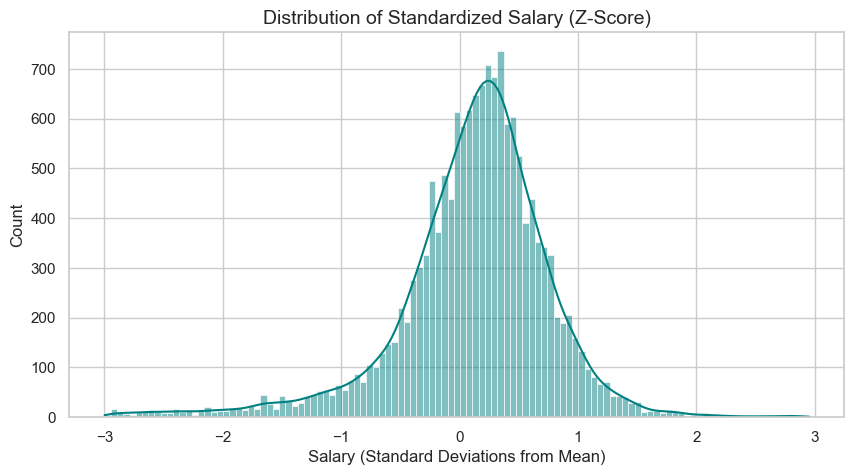

Skewness: -1.00


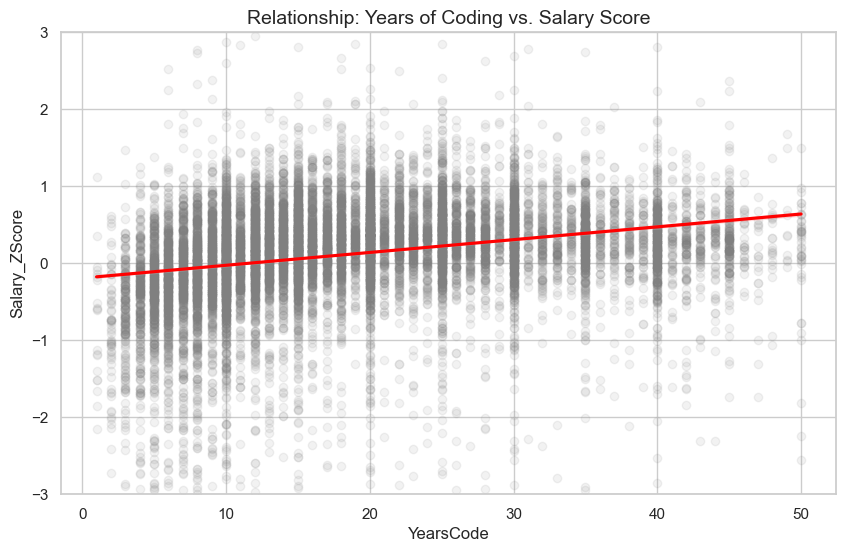

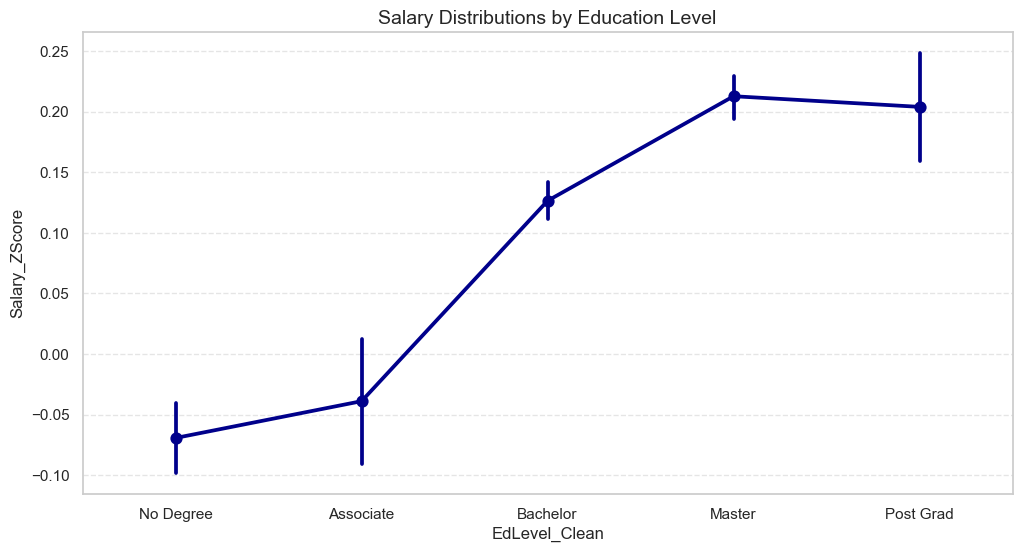

In [281]:
# Define order for categorical variables
edu_order = ['No Degree', 'Associate', 'Bachelor', 'Master', 'Post Grad']

# A. Salary Distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_data['Salary_ZScore'], kde=True, color='teal')
plt.title("Distribution of Standardized Salary (Z-Score)", fontsize=14)
plt.xlabel("Salary (Standard Deviations from Mean)")
plt.show()
print(f"Skewness: {train_data['Salary_ZScore'].skew():.2f}")

# B. Salary vs. Coding Experience
plt.figure(figsize=(10, 6))
sns.regplot(data=train_data, x='YearsCode', y='Salary_ZScore', 
            scatter_kws={'alpha':0.1, 'color':'gray'}, line_kws={'color':'red'})
plt.title("Relationship: Years of Coding vs. Salary Score", fontsize=14)
plt.ylim(-3, 3)
plt.show()

# C. Salary vs. Education
plt.figure(figsize=(12, 6))
sns.pointplot(data=train_data, x='EdLevel_Clean', y='Salary_ZScore', order=edu_order, color='darkblue')
plt.title("Salary Distributions by Education Level", fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

## Correlation matrix
In this section I build a correlation matrix and make first decisions about which variables to keep and which ones to drop.

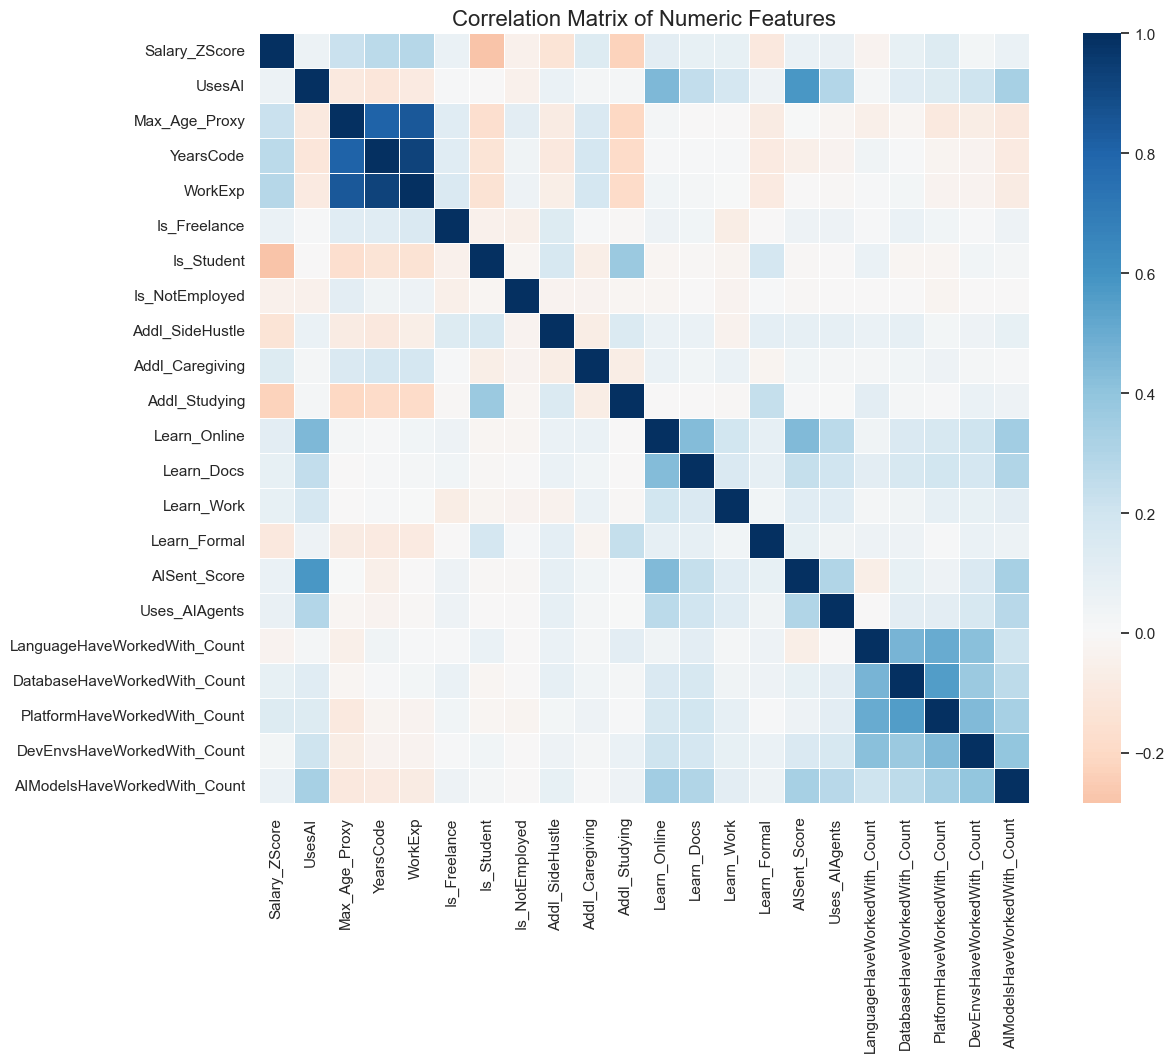

--- Correlation with Salary_ZScore for parameter that significantly impact---
Max_Age_Proxy                   0.22
YearsCode                       0.27
WorkExp                         0.28
Is_Student                     -0.28
Addl_SideHustle                -0.14
Addl_Caregiving                 0.13
Addl_Studying                  -0.23
Learn_Online                    0.11
Learn_Formal                   -0.10
PlatformHaveWorkedWith_Count    0.13
Name: Salary_ZScore, dtype: float64


In [282]:
# Correlation matrix
sns.set_theme(style="whitegrid")
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train_data[numeric_cols].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='RdBu', center=0, square=True, linewidths=.5)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()
print("--- Correlation with Salary_ZScore for parameter that significantly impact---")
salary_correlation_vector = corr_matrix['Salary_ZScore'].drop('Salary_ZScore')
keepers = salary_correlation_vector[np.abs(salary_correlation_vector) >= 0.1]
print(keepers.round(2))

Based on the correlation matrix above for further analysis I select only the variables that have correlation value higher than 0.1, the rest of the values are dropped.

## Model development
In this section I develop a model and use it to further zero down on the most important variables affecting the salary.

                            OLS Regression Results                            
Dep. Variable:          Salary_ZScore   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     248.2
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:34:30   Log-Likelihood:                -13278.
No. Observations:               15179   AIC:                         2.659e+04
Df Residuals:                   15162   BIC:                         2.672e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

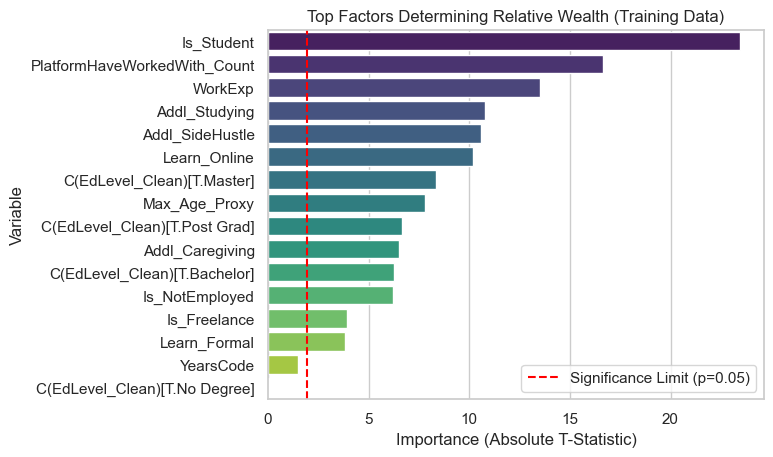

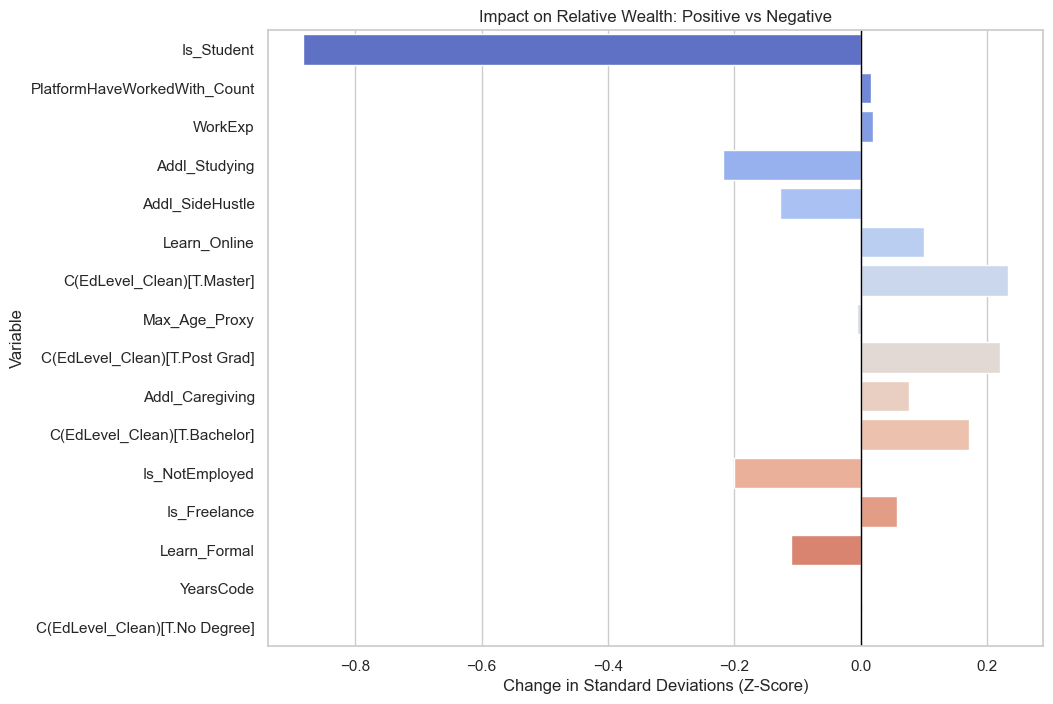

In [283]:
# Model development
formula = """
Salary_ZScore ~ Max_Age_Proxy + WorkExp + YearsCode  +
                        C(EdLevel_Clean) + 
                        Is_Student + Is_Freelance + Is_NotEmployed + 
                        Addl_SideHustle + Addl_Studying + Addl_Caregiving +
                        Learn_Online + Learn_Formal + PlatformHaveWorkedWith_Count          
"""

model = smf.ols(formula=formula, data=train_data).fit()
print(model.summary())

results = pd.DataFrame({
    'Variable': model.params.index,
    'Coefficient': model.params.values,
    'T_Value': model.tvalues.values,
    'Abs_T_Value': model.tvalues.abs()
})

plot_data = results.drop('Intercept', errors='ignore')

sorted_importance = plot_data.sort_values('Abs_T_Value', ascending=False).head(20)

sns.barplot(x='Abs_T_Value', y='Variable', data=sorted_importance, palette='viridis')
plt.title('Top Factors Determining Relative Wealth (Training Data)')
plt.xlabel('Importance (Absolute T-Statistic)')
plt.axvline(x=1.96, color='red', linestyle='--', label='Significance Limit (p=0.05)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))

sns.barplot(x='Coefficient', y='Variable', data=sorted_importance, palette='coolwarm')
plt.title('Impact on Relative Wealth: Positive vs Negative')
plt.xlabel('Change in Standard Deviations (Z-Score)')
plt.axvline(x=0, color='black', linewidth=1)
plt.show()

Based on a Importance graph we can remove YearsCode and C(EdLevel_Clean)[No Degree] as they show no insufficient impact. In addition to that Max_age_proxy is similar to a WorkExp, so it is better to keep only one of them.

## Retrain model
In this section I train the final model with only the selected variables and check its performance by using the testing set. 

In [284]:
# Retrain model with refined parameters
formula = """
Salary_ZScore ~ WorkExp  + C(EdLevel_Clean) + 
                        Is_Student + Is_Freelance + Is_NotEmployed +
                        Addl_SideHustle + Addl_Studying + Addl_Caregiving +
                        Learn_Online + Learn_Formal + PlatformHaveWorkedWith_Count          
"""

model = smf.ols(formula=formula, data=train_data).fit()

## Model evaluation and prediction intervals
In this section I evaluate model performance and identify prediction intervals.

--- Prediction Summary (First 5 Rows) ---


,mean,obs_ci_lower,obs_ci_upper,Actual_Salary_ZScore
0,-0.015156,-1.155759,1.125447,-0.302610
1,0.324635,-0.816079,1.465349,0.476702
2,0.097278,-1.043272,1.237829,0.020646
3,0.123331,-1.017253,1.263915,0.419348
4,0.079837,-1.060904,1.220578,-0.595500



--- Model Performance on Test Set ---
RMSE (Root Mean Squared Error): 0.5845
MAE (Mean Absolute Error):      0.4071


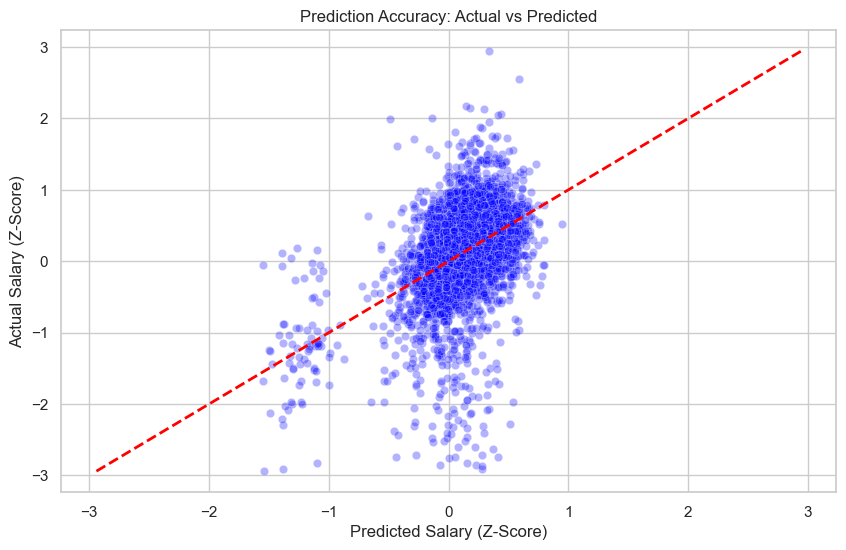


Prediction Interval Coverage: 94.52%


In [285]:
# Linear Regression predictive analysis (with interpretation and prediction intervals)
pred_results = model.get_prediction(test_data)
pred_df = pred_results.summary_frame(alpha=0.05)
pred_df['Actual_Salary_ZScore'] = test_data['Salary_ZScore'].values
pred_df['Residual'] = pred_df['Actual_Salary_ZScore'] - pred_df['mean']

print("--- Prediction Summary (First 5 Rows) ---")
display(pred_df[['mean', 'obs_ci_lower', 'obs_ci_upper', 'Actual_Salary_ZScore']].head())

rmse = np.sqrt(mean_squared_error(pred_df['Actual_Salary_ZScore'], pred_df['mean']))
mae = mean_absolute_error(pred_df['Actual_Salary_ZScore'], pred_df['mean'])

print(f"\n--- Model Performance on Test Set ---")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error):      {mae:.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pred_df['mean'], y=pred_df['Actual_Salary_ZScore'], alpha=0.3, color='blue')
plt.plot([pred_df['Actual_Salary_ZScore'].min(), pred_df['Actual_Salary_ZScore'].max()], 
         [pred_df['Actual_Salary_ZScore'].min(), pred_df['Actual_Salary_ZScore'].max()], 
         color='red', lw=2, linestyle='--')
plt.xlabel("Predicted Salary (Z-Score)")
plt.ylabel("Actual Salary (Z-Score)")
plt.title("Prediction Accuracy: Actual vs Predicted")
plt.show()

pred_df['Inside_Interval'] = (pred_df['Actual_Salary_ZScore'] >= pred_df['obs_ci_lower']) & \
                             (pred_df['Actual_Salary_ZScore'] <= pred_df['obs_ci_upper'])

coverage = pred_df['Inside_Interval'].mean()
print(f"\nPrediction Interval Coverage: {coverage:.2%}")

## Conclusions
### Model performance
This analysis shows that salary of a given worker is defined by multiple parameters and correlation between any single variable is generally weak. R-squared of 0.208 could be considered low for physics or engineering, but for social science this seems appropriate, since any individual's salary can be defined by more than one parameter, and sometimes comes down to luck. Despite this noise, the model is highly reliable because it achieved a Prediction Interval Coverage of 94.52%. This confirms that predicting exact salary numbers with perfect precision is very hard, the model still captures the range of expected salary for the vast majority of people. Given this complexity, the outcome of this model is a success nonetheless.

### Dominant predictors
Work experience and education were expectedly the most valuable predictors of salary, positively correlating with the result. The status of being a student also expectedly negatively correlated with the salary, since most students are either working for a small stipend or part time.

# Generalized Linear Model


## Visualizations
In this section I construct some graphs to see the relationship with the AI usage (target variable for GLM).

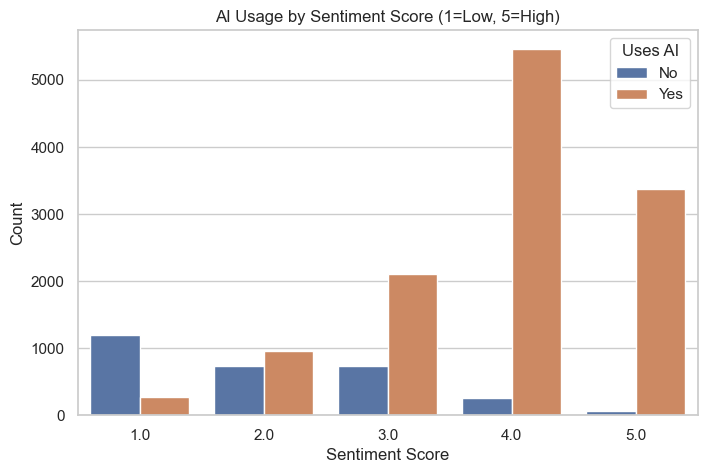

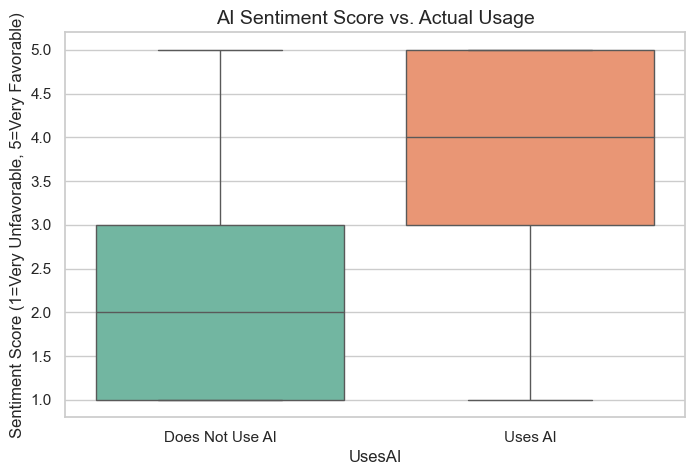

In [286]:
# Visualizations
# Do people with positive sentiment use AI more?
plt.figure(figsize=(8, 5))
sns.countplot(x='AISent_Score', hue='UsesAI', data=train_data)
plt.title('AI Usage by Sentiment Score (1=Low, 5=High)')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend(title='Uses AI', labels=['No', 'Yes'])
plt.show()

# Does AI sentiment affect Usage?
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_data, x='UsesAI', y='AISent_Score', palette="Set2")
plt.title("AI Sentiment Score vs. Actual Usage", fontsize=14)
plt.xticks([0, 1], ['Does Not Use AI', 'Uses AI'])
plt.ylabel("Sentiment Score (1=Very Unfavorable, 5=Very Favorable)")
plt.show()

It seems obvious from the plots above that people who have a higher sentiment for AI also use it more frequently. It was also shown by the correlation matrix in the first part of this project.

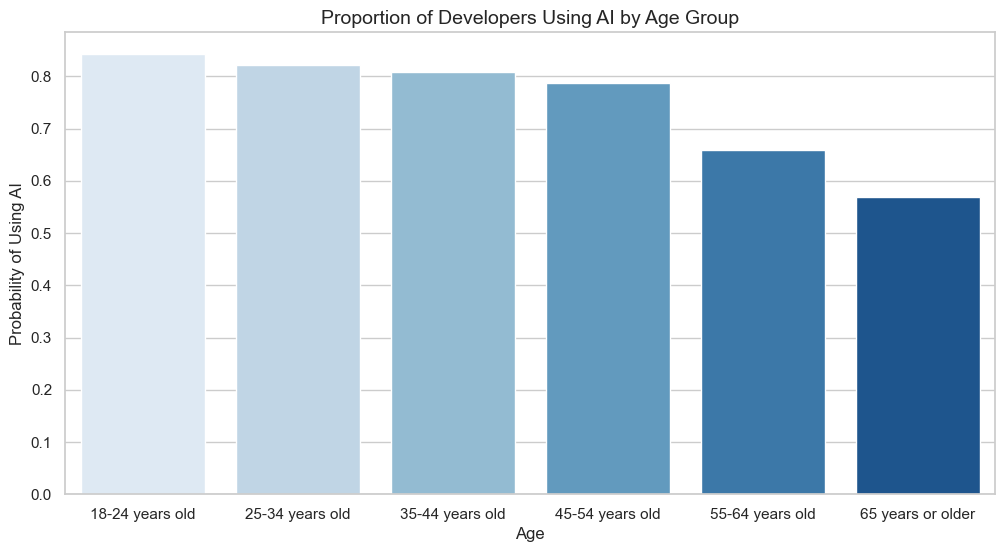

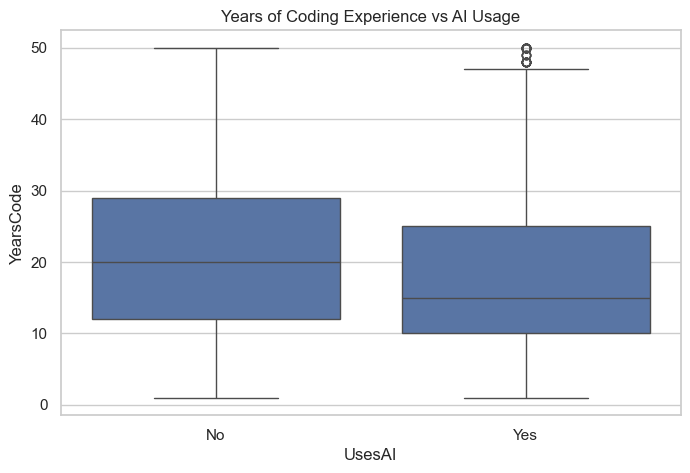

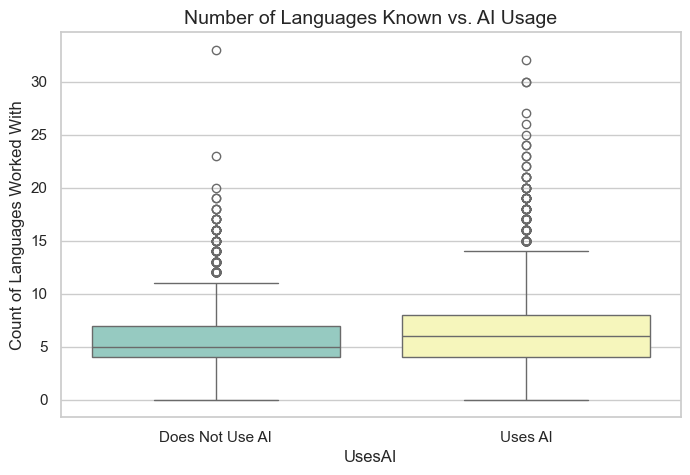

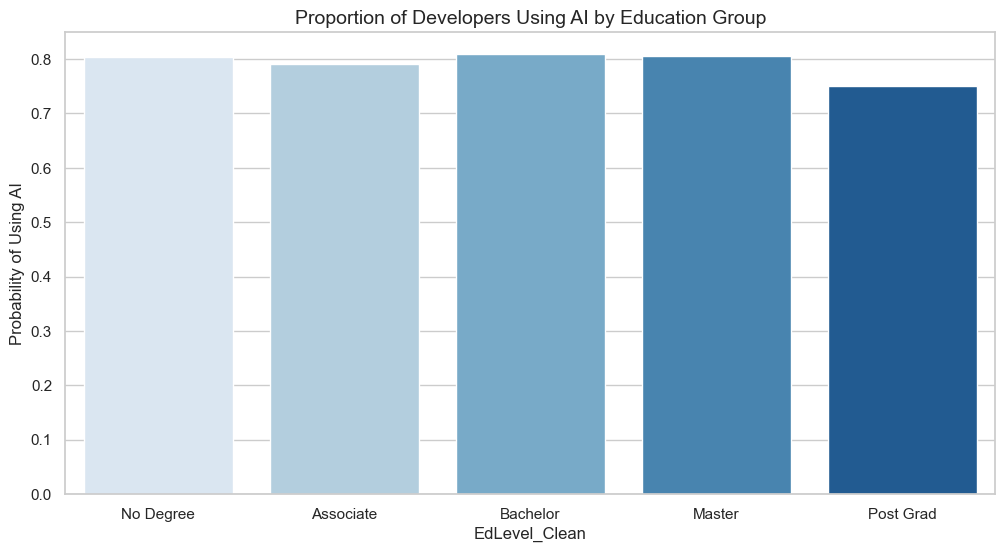

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

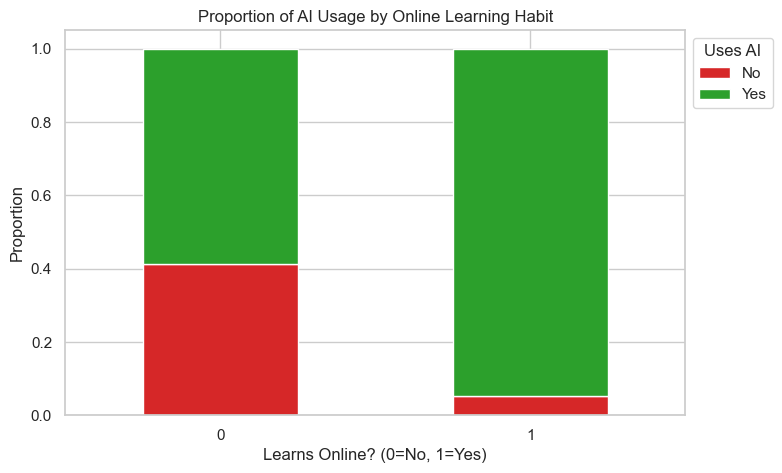

In [287]:
age_order = ['18-24 years old', '25-34 years old', '35-44 years old', 
             '45-54 years old', '55-64 years old', '65 years or older']

# Which age group uses uses AI more?
plt.figure(figsize=(12, 6))
sns.barplot(data=train_data, x='Age', y='UsesAI', order=age_order, palette="Blues", errorbar=None)
plt.title("Proportion of Developers Using AI by Age Group", fontsize=14)
plt.ylabel("Probability of Using AI")
plt.show()

# Does coding experience affect AI usage?
plt.figure(figsize=(8, 5))
sns.boxplot(x='UsesAI', y='YearsCode', data=train_data)
plt.title('Years of Coding Experience vs AI Usage')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Do heavier coders use AI?
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_data, x='UsesAI', y='LanguageHaveWorkedWith_Count', palette="Set3")
plt.title("Number of Languages Known vs. AI Usage", fontsize=14)
plt.xticks([0, 1], ['Does Not Use AI', 'Uses AI'])
plt.ylabel("Count of Languages Worked With")
plt.show()

# Does AI usage depend on educational level?
plt.figure(figsize=(12, 6))
sns.barplot(data=train_data, x='EdLevel_Clean', y='UsesAI', order=edu_order, palette="Blues", errorbar=None)
plt.title("Proportion of Developers Using AI by Education Group", fontsize=14)
plt.ylabel("Probability of Using AI")
plt.show()

# If user learnt Online
ct = pd.crosstab(train_data['Learn_Online'], train_data['UsesAI'], normalize='index')
ct.plot(kind='bar', stacked=True, color=['#d62728', '#2ca02c'], figsize=(8, 5))
plt.title('Proportion of AI Usage by Online Learning Habit')
plt.xlabel('Learns Online? (0=No, 1=Yes)')
plt.ylabel('Proportion')
plt.legend(title='Uses AI', labels=['No', 'Yes'], loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=0)

The graphs above reveal the following information:
- Younger people use AI more, than older people. Moreover the usage seem to drop linearly with age.
- People who use AI generally have less coding experience. People with more years of experience rely on AI less.
- People who use AI generally code in more programming languages than people who don't.
- People with post graduate level of education are less likely to use AI, but generally people with any education adopt use of AI.
- People who learnt online are more likely to adopt AI usage.

## Model development
In this section I develop GLM model only taking into account the variables that seem relevant. I refer to Correlation matrix graph that I have built in the first part of this assignment. 

In [288]:
# GLM model development and interpretation
formula_glm = """
UsesAI ~ AISent_Score + Uses_AIAgents +
    C(Age) + YearsCode + C(EdLevel_Clean) + 
    LanguageHaveWorkedWith_Count + DatabaseHaveWorkedWith_Count + PlatformHaveWorkedWith_Count + DevEnvsHaveWorkedWith_Count + AIModelsHaveWorkedWith_Count +
    Learn_Online + Learn_Docs + Learn_Work
"""

model_glm = smf.glm(formula=formula_glm, data=train_data, family=sm.families.Binomial()).fit()
print(model_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 UsesAI   No. Observations:                15179
Model:                            GLM   Df Residuals:                    15158
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3722.0
Date:                Sun, 14 Dec 2025   Deviance:                       7444.1
Time:                        21:34:31   Pearson chi2:                 2.75e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3945
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

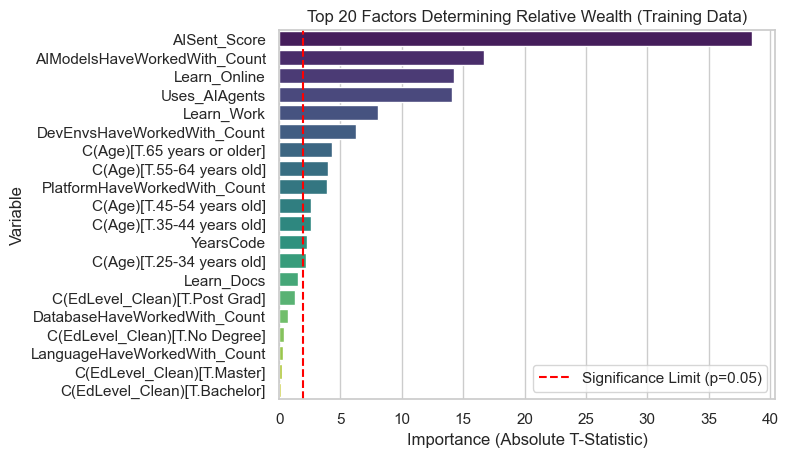

In [289]:
results_glm = pd.DataFrame({
    'Variable': model_glm.params.index,
    'Coefficient': model_glm.params.values,
    'T_Value': model_glm.tvalues.values,
    'Abs_T_Value': model_glm.tvalues.abs()
})

plot_data = results_glm.drop('Intercept', errors='ignore')

sorted_importance = plot_data.sort_values('Abs_T_Value', ascending=False).head(20)

sns.barplot(x='Abs_T_Value', y='Variable', data=sorted_importance, palette='viridis')
plt.title('Top 20 Factors Determining Relative Wealth (Training Data)')
plt.xlabel('Importance (Absolute T-Statistic)')
plt.axvline(x=1.96, color='red', linestyle='--', label='Significance Limit (p=0.05)')
plt.legend()
plt.show()

## Retrain model
Based on the information from the previous section I drop the values that have the least effect and train the final model.

In [290]:
# Final model
formula_glm = """
UsesAI ~ AISent_Score + Uses_AIAgents +
    C(Age) + YearsCode + 
    PlatformHaveWorkedWith_Count + DevEnvsHaveWorkedWith_Count + AIModelsHaveWorkedWith_Count +
    Learn_Online + Learn_Work
"""

model_glm = smf.glm(formula=formula_glm, data=train_data, family=sm.families.Binomial()).fit()

## Model evaluation
In this section I evaluate the performance of the model on test dataset.


--- GLM Accuracy: 89.46% ---

Confusion Matrix:
[[ 492  257]
 [ 143 2903]]


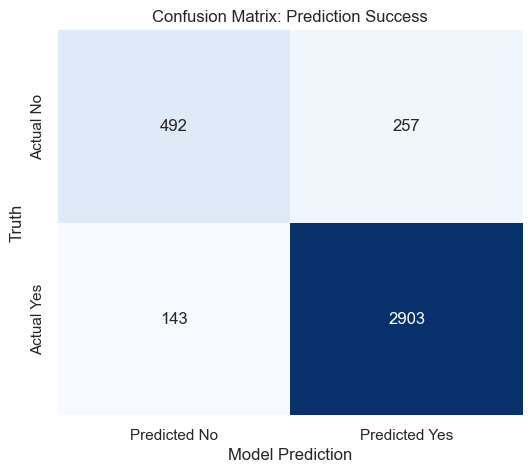

Classification Report


,precision,recall,f1-score,support,Interpretation
0,0.77,0.66,0.71,749,Correctly identified 66% of Non-users
1,0.92,0.95,0.94,3046,Correctly identified 95% of AI users
accuracy,0.89,0.89,0.89,0,Overall % of correct predictions
macro avg,0.85,0.80,0.82,3795,Average performance across classes
weighted avg,0.89,0.89,0.89,3795,


In [291]:
# GLM predictive performance
test_data['Prob_UsesAI'] = model_glm.predict(test_data)
test_data['Pred_UsesAI'] = (test_data['Prob_UsesAI'] > 0.5).astype(int)

conf_matrix = confusion_matrix(test_data['UsesAI'], test_data['Pred_UsesAI'])
acc = accuracy_score(test_data['UsesAI'], test_data['Pred_UsesAI'])

print(f"\n--- GLM Accuracy: {acc:.2%} ---")
print("\nConfusion Matrix:")
print(conf_matrix)

# Confusion matrix graphic
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix: Prediction Success')
plt.ylabel('Truth')
plt.xlabel('Model Prediction')
plt.show()

# Classification report
report_dict = classification_report(test_data['UsesAI'], test_data['Pred_UsesAI'], output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report['Interpretation'] = ""
df_report.loc['0', 'Interpretation'] = "Correctly identified 66% of Non-users"
df_report.loc['1', 'Interpretation'] = "Correctly identified 95% of AI users"
df_report.loc['accuracy', 'Interpretation'] = "Overall % of correct predictions"
df_report.loc['macro avg', 'Interpretation'] = "Average performance across classes"
cols_to_format = ['precision', 'recall', 'f1-score']
df_report[cols_to_format] = df_report[cols_to_format].applymap(lambda x: f"{x:.2f}")
df_report['support'] = df_report['support'].astype(int)
print("Classification Report")
display(df_report)




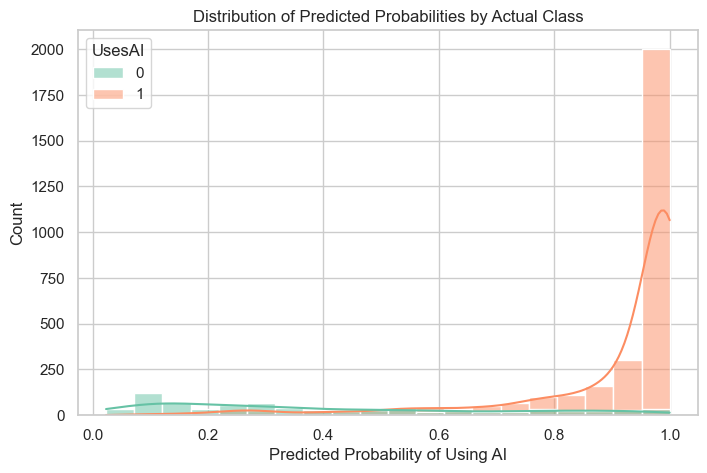

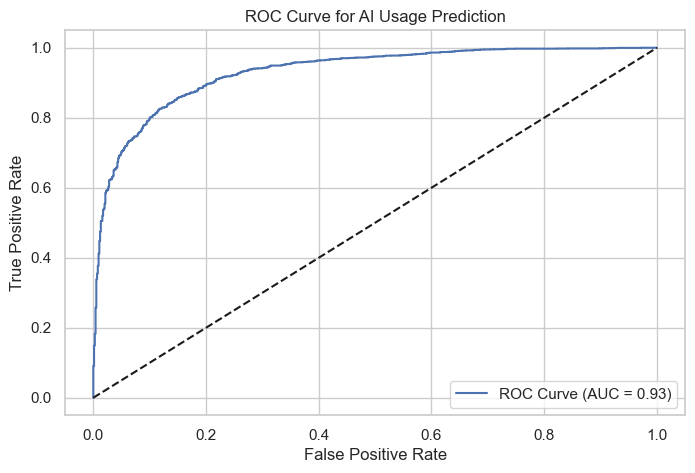

In [292]:
plt.figure(figsize=(8, 5))
sns.histplot(data=test_data, x='Prob_UsesAI', hue='UsesAI', kde=True, bins=20, palette='Set2')
plt.title("Distribution of Predicted Probabilities by Actual Class")
plt.xlabel("Predicted Probability of Using AI")
plt.show()

fpr, tpr, _ = roc_curve(test_data['UsesAI'], test_data['Prob_UsesAI'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AI Usage Prediction')
plt.legend(loc='lower right')
plt.show()

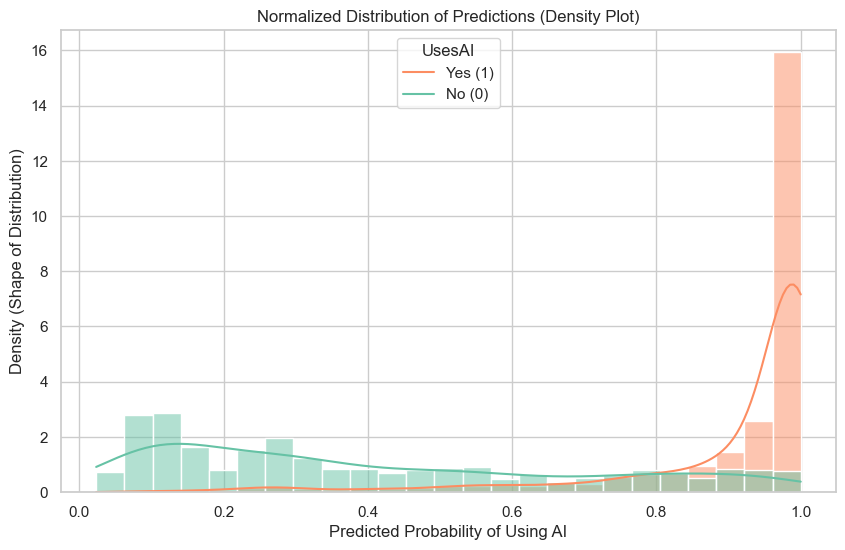

In [293]:
# Rebuilding the plot to account for difference in distribution, since more people use AI than those who don't.
plt.figure(figsize=(10, 6))
sns.histplot(
    data=test_data, 
    x='Prob_UsesAI', 
    hue='UsesAI', 
    kde=True, 
    bins=25, 
    palette='Set2', 
    stat="density",      
    common_norm=False    
)

plt.title("Normalized Distribution of Predictions (Density Plot)")
plt.xlabel("Predicted Probability of Using AI")
plt.ylabel("Density (Shape of Distribution)")
plt.legend(title='UsesAI', labels=['Yes (1)', 'No (0)'], loc='upper center')
plt.show()

## Prediction intervals
In this section I define and display prediction intervals.

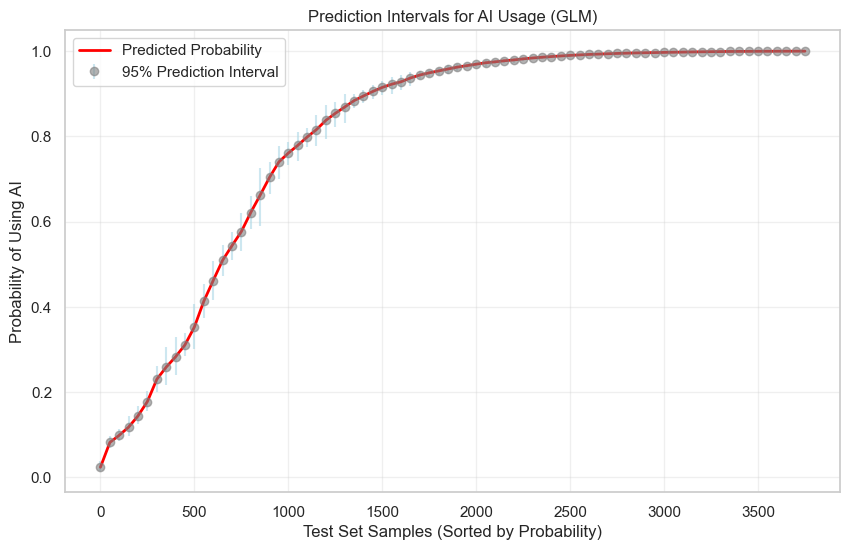


--- Prediction Intervals (First 5 Samples) ---


,UsesAI,Prob_UsesAI,prob_lower_ci,prob_upper_ci
0,1,0.679598,0.645568,0.711819
1,1,0.998654,0.997964,0.999110
2,1,0.991015,0.987928,0.993317
3,1,0.974336,0.966844,0.980169
4,1,0.856965,0.834861,0.876549


In [294]:
# Prediction intervals for GLM

clean_test = test_data.copy().reset_index(drop=True)
pred_results = model_glm.get_prediction(clean_test)
summary_frame = pred_results.summary_frame(alpha=0.05)

clean_test['Prob_UsesAI'] = summary_frame['mean']
clean_test['prob_lower_ci'] = summary_frame['mean_ci_lower']
clean_test['prob_upper_ci'] = summary_frame['mean_ci_upper']

subset = clean_test.sort_values('Prob_UsesAI').reset_index(drop=True)
subset = subset.iloc[::50] 

plt.figure(figsize=(10, 6))
lower_error = subset['Prob_UsesAI'] - subset['prob_lower_ci']
upper_error = subset['prob_upper_ci'] - subset['Prob_UsesAI']

plt.errorbar(subset.index, subset['Prob_UsesAI'], 
             yerr=[lower_error, upper_error], 
             fmt='o', color='gray', ecolor='lightblue', alpha=0.6, label='95% Prediction Interval')

plt.plot(subset.index, subset['Prob_UsesAI'], color='red', linewidth=2, label='Predicted Probability')

plt.ylabel('Probability of Using AI')
plt.xlabel('Test Set Samples (Sorted by Probability)')
plt.title('Prediction Intervals for AI Usage (GLM)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- Prediction Intervals (First 5 Samples) ---")
display(clean_test[['UsesAI', 'Prob_UsesAI', 'prob_lower_ci', 'prob_upper_ci']].head())

## Conclusions
In this part of the project I have developed a Generalized Linear Model and used it to predict whether a given user uses AI or not in their work. The model demonstrated strong predictive performance on the test set, with accuracy of 89.46% and an AUC of 0.93.

The confusion matrix indicated that the model is very effective at identifying users of AI (true positives 2903, sensitivity 0.95) and less effective at identifying non-users (492 true negatives, 143 false negatives).

The density plot of predicted probabilities supports these findings. A sharp, high peak for the 'Uses AI' class (with density of approx. 16), indicates the model is highly confident and consistent in identifying AI users. The 'No AI' class has a lower, broader distribution (Density ~3), suggesting slightly more variance in the probabilities for non-users, though the two distributions are clearly separated, consistent with the high AUC of 0.93.

Prediction intervals were calculated for the estimated probabilities. As shown in the interval plot, observations with high predicted probabilities (near 1.0) exhibit narrow intervals, reflecting high model certainty. Conversely, observations near the decision boundary (0.5) show wider intervals, reflecting greater uncertainty in classification for those specific cases.